# Part 1(a)

Submitted by: Niv.S 0895, Itay.M 4440 

Email: niv.saban@gmail.com, itaym435@gmail.com

Dataset: Titanic

Objective: To classify Titanic passengers as survived or not survived based on their personal attributes.

# Part 1(b)
AI agent that used - Chat-GPT & Gemini

"Create a bar chart for survival rates by gender, a histogram for the age distribution of survivors, and a scatter plot showing the relationship between SibSp and Parch for survivors."

"Normalize the Age and Fare columns in the dataset."

"Write the code for KNN and Decision Tree algorithms, including a GridSearchCV to tune at least two relevant hyperparameters for each algorithm."

"Compare the performance of the algorithms with and without data normalization."

"Create a visualization of the models' performance as a function of the feature selection results."

"Display the results in a table showing the individual scores for each of the 5 cross-validation folds, along with the mean score for each permutation."

"Generate a classification report for the final model on the test set, displaying precision, recall, and F1 scores for each class in a clear tabular format."

"Predict on the independent test set, display the first 5 predictions vs. true labels, plot the confusion matrix, and evaluate model stability with 5-fold F1-macro cross-validation."

# בעיית הלמידה והdataSet

בעיית הלמידה היא משימת סיווג בינארי שמטרתה לחזות האם נוסע על ספינת הטיטאניק שרד את האסון (ערך 1) או לא (ערך 0). סט הנתונים (dataset) מספק מידע דמוגרפי ופרטי נסיעה על הנוסעים, הכולל מאפיינים מרכזיים כמו מין, גיל, מחלקת הנסיעה (Pclass), מספר בני המשפחה על הסיפון (SibSp, Parch), והמחיר ששולם עבור הכרטיס (Fare). באמצעות מאפיינים אלו, המטרה היא לאמן מודל חיזוי שיוכל להכליל ולסווג באופן מדויק את תוצאת ההישרדות עבור נוסעים שטרם נראו.

# חלק 2 - הכנה, טעינה, EDA:

טעינת ספריות וקריאת מערכי הנתונים של ה־train וה־test:


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import confusion_matrix

In [3]:
train_df = pd.read_csv("titanic_train.csv")
test_df =  pd.read_csv("titanic_test.csv")

print("Head of - titanic_train.csv")
display(train_df.head())
print("Head of - titanic_test.csv")
display(test_df.head())

Head of - titanic_train.csv


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


Head of - titanic_test.csv


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,35.000000,0,0,7.0500,0,0
1,3,1,30.000000,0,0,7.2500,0,0
2,3,1,29.699118,0,0,14.5000,0,0
3,3,0,21.000000,0,0,7.7500,2,0
4,3,1,32.000000,0,0,56.4958,0,1


**ויזואליזציה 1: סטטיסטיקה תיאורית עבור השורדים**

**תועלת:** מספקת תובנות סטטיסטיות (ממוצע, סטיית תקן, רבעונים) על השורדים בלבד. זה עוזר לנו להבין את גילם הטיפוסי, מחיר הכרטיס ששילמו, ותכונות הקשורות למשפחה.


In [16]:
survived_df = train_df[train_df["Survived"] == 1]
survived_df.describe(include="all")

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
count,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.0
mean,1.957295,0.313167,28.344165,0.487544,0.459075,48.683468,0.451957,1.0
std,0.873187,0.464609,13.552237,0.717651,0.778688,68.767186,0.664405,0.0
min,1.000000,0.000000,0.670000,0.000000,0.000000,0.000000,0.000000,1.0
25%,1.000000,0.000000,22.000000,0.000000,0.000000,12.475000,0.000000,1.0
50%,2.000000,0.000000,29.699118,0.000000,0.000000,26.000000,0.000000,1.0
75%,3.000000,1.000000,35.000000,1.000000,1.000000,57.000000,1.000000,1.0
max,3.000000,1.000000,80.000000,4.000000,5.000000,512.329200,3.000000,1.0


**ויזואליזציה 2: תרשים עמודות של שיעורי השרידות לפי מגדר**

**תועלת:** מאפשר השוואה ויזואלית פשוטה של שיעורי השרידות בין גברים לנשים, ומדגיש דפוסים ברורים.


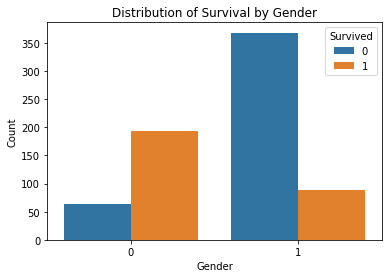

In [17]:
sns.countplot(x="Sex", hue="Survived", data=train_df)
plt.title("Distribution of Survival by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

**ויזואליזציה 3: התפלגות גיל אצל השורדים**

**תועלת:** מראה האם גילאים צעירים או מבוגרים נטו לשרוד יותר, ומדגיש קבוצות סיכון מול קבוצות מוגנות



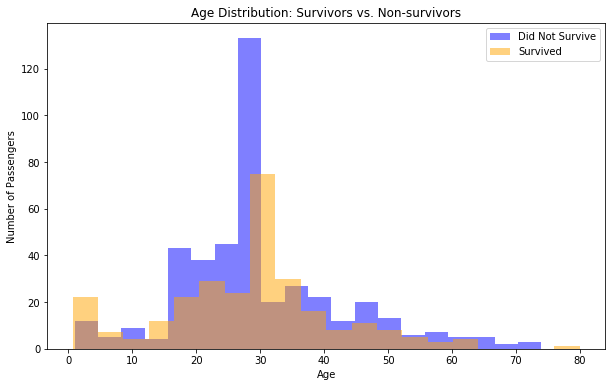

In [12]:
# יצירת גרף
plt.figure(figsize=(10, 6))

# התפלגות גילאים של מי שלא שרדו (Survived == 0)
train_df[train_df['Survived'] == 0]['Age'].dropna().plot(kind='hist', bins=20, alpha=0.5, label='Did Not Survive', color='blue')

# התפלגות גילאים של מי ששרדו (Survived == 1)
train_df[train_df['Survived'] == 1]['Age'].dropna().plot(kind='hist', bins=20, alpha=0.5, label='Survived', color='orange')

plt.title("Age Distribution: Survivors vs. Non-survivors")
plt.xlabel("Age")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()

**ויזואליזציה 4: קשר בין SibSp ל־Parch אצל השורדים**

**תועלת:** מאפשר להבין את השפעת מבנה המשפחה על השרידות, ובפרט אם למשפחות מסוג מסויים היה סיכוי טוב יותר לשרוד.

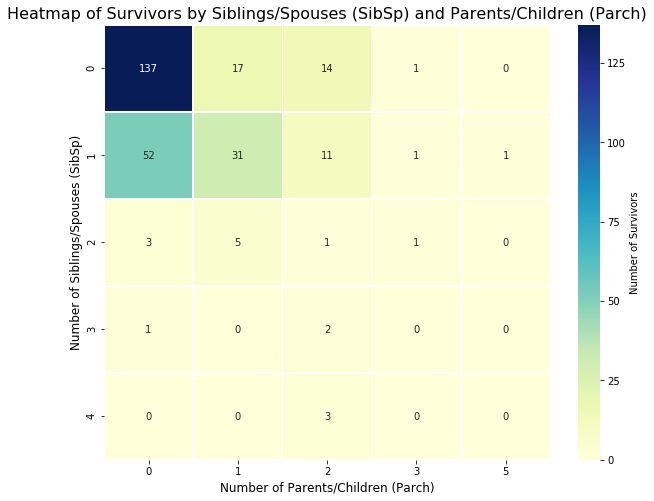

In [13]:

survivors_df = train_df[train_df['Survived'] == 1]

survivor_family_crosstab = pd.crosstab(survivors_df['SibSp'], survivors_df['Parch'])

plt.figure(figsize=(10, 8))

sns.heatmap(survivor_family_crosstab,
            annot=True,     # Show the numerical values on the map
            fmt='d',        # Format the numbers as integers
            cmap='YlGnBu',  # Choose a color palette
            linewidths=.5,  # Add lines between cells for better separation
            cbar_kws={'label': 'Number of Survivors'}) # Label the color bar

plt.title('Heatmap of Survivors by Siblings/Spouses (SibSp) and Parents/Children (Parch)', fontsize=16)
plt.xlabel('Number of Parents/Children (Parch)', fontsize=12)
plt.ylabel('Number of Siblings/Spouses (SibSp)', fontsize=12)

plt.show()

# חלק 3 הניסויים:

Feature Engineering

תהליך הנדסת המאפיינים (Feature Engineering) בפרויקט זה כלל מספר שלבים קריטיים להכנת הנתונים, אשר בוצעו באופן מאורגן באמצעות ColumnTransformer. ראשית, המאפיינים חולקו לשתי קבוצות: נומריים וקטגוריאליים. על המאפיינים הנומריים (כגון 'Age' ו-'Fare') הופעל נירמול (StandardScaler) על מנת להביאם לסולם אחיד, שלב שהינו חיוני במיוחד עבור מודלים הרגישים למרחקים כמו KNN. במקביל, המאפיינים הקטגוריאליים (כגון 'Pclass' ו-'Sex') עברו קידוד מסוג OneHotEncoder שהמיר אותם לייצוג מספרי בינארי

In [19]:
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- שלב 2: בניית תהליך עיבוד הנתונים המקדים (Preprocessor) ---
numeric_features = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_features = ['Pclass', 'Sex', 'Embarked']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

**התנסות במודלים**


In [40]:
# --- GridSearch KNN עם Feature Selection ---
pipeline_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectKBest(score_func=f_classif)),
    ('classifier', KNeighborsClassifier())
])

param_grid_knn = {
    'preprocessor__numeric__scaler': [StandardScaler(), None],
    'feature_selector__k': [3, 5, 7, 9],
    'classifier__n_neighbors': [5, 7, 9],
    'classifier__weights': ['uniform', 'distance']
}

grid_search_kbest_knn = GridSearchCV(
    pipeline_knn, param_grid_knn, cv=5, scoring='f1_macro', verbose=0, return_train_score=False
)
grid_search_kbest_knn.fit(X_train, y_train)

# --- GridSearch Decision Tree עם Feature Selection ---
pipeline_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectKBest(score_func=f_classif)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

param_grid_dt = {
    'preprocessor__numeric__scaler': [StandardScaler(), None],
    'feature_selector__k': [3, 5, 7],
    'classifier__max_depth': [5, 7, 10],
    'classifier__min_samples_leaf': [5, 10]
}

grid_search_kbest_dt = GridSearchCV(
    pipeline_dt, param_grid_dt, cv=5, scoring='f1_macro', verbose=0, return_train_score=False
)
grid_search_kbest_dt.fit(X_train, y_train)

# --- יצירת DataFrame להצגה עם שמות עמודות נקיים ---
results_knn_df = pd.DataFrame(grid_search_kbest_knn.cv_results_)
results_dt_df = pd.DataFrame(grid_search_kbest_dt.cv_results_)

# --- עמודות נקיות ל-KNN ---
cols_knn = [
    'param_classifier__n_neighbors',
    'param_classifier__weights',
    'param_feature_selector__k',
    'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score',
    'mean_test_score',
    'rank_test_score'
]

# --- עמודות נקיות ל-Decision Tree ---
cols_dt = [
    'param_classifier__max_depth',
    'param_classifier__min_samples_leaf',
    'param_feature_selector__k',
    'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score',
    'mean_test_score',
    'rank_test_score'
]

# --- הצגת Top 10 KNN ---
display(
    results_knn_df[cols_knn]
    .rename(columns={
        'param_classifier__n_neighbors': 'n_neighbors',
        'param_classifier__weights': 'weights',
        'param_feature_selector__k': 'k_features',
        'split0_test_score': 'fold_0',
        'split1_test_score': 'fold_1',
        'split2_test_score': 'fold_2',
        'split3_test_score': 'fold_3',
        'split4_test_score': 'fold_4',
        'mean_test_score': 'mean_score',
        'rank_test_score': 'rank'
    })
    .sort_values(by='rank')
    .head(10)
)

# --- הצגת Top 10 Decision Tree ---
display(
    results_dt_df[cols_dt]
    .rename(columns={
        'param_classifier__max_depth': 'max_depth',
        'param_classifier__min_samples_leaf': 'min_samples_leaf',
        'param_feature_selector__k': 'k_features',
        'split0_test_score': 'fold_0',
        'split1_test_score': 'fold_1',
        'split2_test_score': 'fold_2',
        'split3_test_score': 'fold_3',
        'split4_test_score': 'fold_4',
        'mean_test_score': 'mean_score',
        'rank_test_score': 'rank'
    })
    .sort_values(by='rank')
    .head(10)
)


C:\Users\nivsa\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,n_neighbors,weights,k_features,fold_0,fold_1,fold_2,fold_3,fold_4,mean_score,rank
34,9,uniform,5,0.833442,0.788176,0.777249,0.823429,0.726575,0.789885,1
36,9,uniform,7,0.791159,0.809556,0.752422,0.821802,0.737209,0.782509,2
10,5,distance,5,0.817775,0.801080,0.744246,0.824913,0.710328,0.779790,3
26,7,distance,5,0.834783,0.792659,0.746771,0.804842,0.710328,0.777995,4
44,9,distance,7,0.817775,0.757288,0.777922,0.796429,0.739460,0.777842,5
18,7,uniform,5,0.807973,0.773810,0.741497,0.804842,0.737209,0.773129,6
38,9,uniform,9,0.806483,0.752422,0.741497,0.833442,0.729017,0.772649,7
11,5,distance,5,0.821802,0.771467,0.751192,0.814935,0.694169,0.770847,8
42,9,distance,5,0.834783,0.766154,0.746771,0.804842,0.688861,0.768422,9
46,9,distance,9,0.796429,0.760645,0.759416,0.791159,0.720850,0.765778,10


,max_depth,min_samples_leaf,k_features,fold_0,fold_1,fold_2,fold_3,fold_4,mean_score,rank
33,10,10,5,0.823429,0.759916,0.782135,0.847645,0.745432,0.791793,1
21,7,10,5,0.823429,0.759916,0.782135,0.847645,0.745432,0.791793,1
20,7,10,5,0.823429,0.759916,0.782135,0.847645,0.745432,0.791793,1
32,10,10,5,0.823429,0.759916,0.782135,0.847645,0.745432,0.791793,1
8,5,10,5,0.828600,0.732007,0.779793,0.847645,0.741503,0.785988,5
9,5,10,5,0.828600,0.732007,0.779793,0.847645,0.741503,0.785988,5
2,5,5,5,0.823429,0.719902,0.782135,0.842015,0.735063,0.780589,7
3,5,5,5,0.823429,0.719902,0.782135,0.842015,0.735063,0.780589,7
30,10,10,3,0.806483,0.754960,0.775958,0.796429,0.739460,0.774720,9
31,10,10,3,0.806483,0.754960,0.775958,0.796429,0.739460,0.774720,9


הצגה ויזואלית של היחס בין האלוגריתמים לפני נירמול הנתונים ולאחר מכן

--- Running GridSearchCV for KNN (with/without scaling) ---
Done.

--- Running GridSearchCV for Decision Tree (with/without scaling) ---
Done.



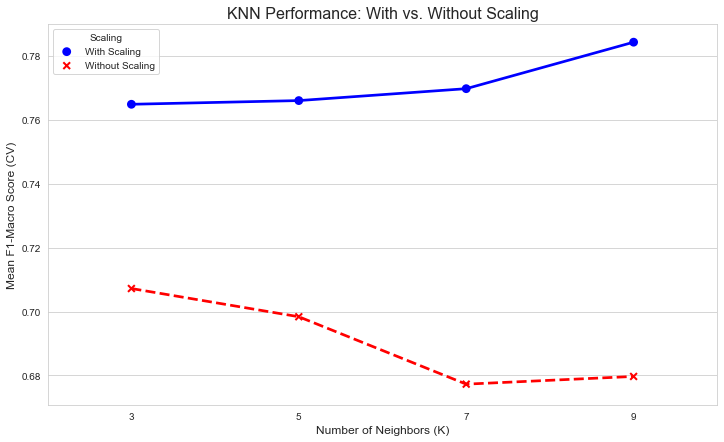

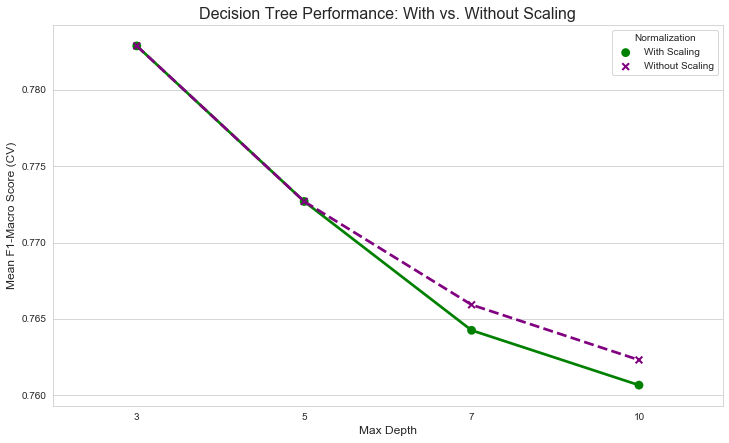

In [37]:
# --- הגדרת פונקציה לעיצוב שם הסקיילר ---
def clean_scaler_name(scaler):
    if isinstance(scaler, StandardScaler):
        return 'With Scaling'
    return 'Without Scaling'

# --- GridSearch עבור KNN (עם ובלי נירמול) ---
print("--- Running GridSearchCV for KNN (with/without scaling) ---")
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])
param_grid_knn = {
    'preprocessor__numeric__scaler': [StandardScaler(), None],
    'classifier__n_neighbors': [3, 5, 7, 9]
}
grid_search_knn_scaling = GridSearchCV(knn_pipeline, param_grid_knn, cv=5, scoring='f1_macro')
grid_search_knn_scaling.fit(X_train, y_train)

# יצירת DataFrame מהתוצאות *אחרי* הריצה
knn_results_df = pd.DataFrame(grid_search_knn_scaling.cv_results_)
knn_results_df['Scaler Type'] = knn_results_df['param_preprocessor__numeric__scaler'].apply(clean_scaler_name)
print("Done.\n")

# --- GridSearch עבור Decision Tree (עם ובלי נירמול) ---
print("--- Running GridSearchCV for Decision Tree (with/without scaling) ---")
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
param_grid_dt = {
    'preprocessor__numeric__scaler': [StandardScaler(), None],
    'classifier__max_depth': [3, 5, 7, 10]
}
grid_search_dt_scaling = GridSearchCV(dt_pipeline, param_grid_dt, cv=5, scoring='f1_macro')
grid_search_dt_scaling.fit(X_train, y_train)

# יצירת DataFrame מהתוצאות *אחרי* הריצה
dt_results_df = pd.DataFrame(grid_search_dt_scaling.cv_results_)
dt_results_df['Scaler Type'] = dt_results_df['param_preprocessor__numeric__scaler'].apply(clean_scaler_name)
print("Done.\n")

# --- ויזואליזציה 2: ניתוח השפעת הנירמול על KNN ---
plt.figure(figsize=(12, 7))
sns.pointplot(data=knn_results_df, x='param_classifier__n_neighbors', y='mean_test_score', hue='Scaler Type', palette={'With Scaling': 'blue', 'Without Scaling': 'red'}, markers=['o', 'x'], linestyles=['-', '--'])
plt.title('KNN Performance: With vs. Without Scaling', fontsize=16)
plt.xlabel('Number of Neighbors (K)', fontsize=12)
plt.ylabel('Mean F1-Macro Score (CV)', fontsize=12)
plt.legend(title='Scaling')
plt.show()

# --- ויזואליזציה 3: ניתוח השפעת הנירמול על עץ החלטה ---
plt.figure(figsize=(12, 7))
sns.pointplot(data=dt_results_df, x='param_classifier__max_depth', y='mean_test_score', hue='Scaler Type', palette={'With Scaling': 'green', 'Without Scaling': 'purple'}, markers=['o', 'x'], linestyles=['-', '--'])
plt.title('Decision Tree Performance: With vs. Without Scaling', fontsize=16)
plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Mean F1-Macro Score (CV)', fontsize=12)
plt.legend(title='Normalization')
plt.show()

בחירת האלגוריתם המנצח עם הפרומטציות המוצלחות ביותר

In [34]:
# --- הכרזת האלגוריתם המנצח ---
best_score_knn = grid_search_kbest_knn.best_score_
best_score_dt = grid_search_kbest_dt.best_score_
best_k_knn = grid_search_kbest_knn.best_params_['feature_selector__k']
best_k_dt = grid_search_kbest_dt.best_params_['feature_selector__k']

print("\n" + "="*50)
print("     Final Conclusion & Winning Model")
print("="*50)

if best_score_knn > best_score_dt:
    print("🏆 The winning model is: KNN with SelectKBest")
    print(f"   - Best Mean Score: {best_score_knn:.4f}")
    print(f"   - Optimal Number of Features: {best_k_knn}")
    print(f"   - Best Parameters: {grid_search_kbest_knn.best_params_}")
elif best_score_dt > best_score_knn:
    print("🏆 The winning model is: Decision Tree with SelectKBest")
    print(f"   - Best Mean Score: {best_score_dt:.4f}")
    print(f"   - Optimal Number of Features: {best_k_dt}")
    print(f"   - Best Parameters: {grid_search_kbest_dt.best_params_}")
else:
    print("🏆 It's a tie! Both models achieved the same mean score.")
    print(f"   - KNN: Score {best_score_knn:.4f} with {best_k_knn} features.")
    print(f"   - Decision Tree: Score {best_score_dt:.4f} with {best_k_dt} features.")


     Final Conclusion & Winning Model
🏆 The winning model is: Decision Tree with SelectKBest
   - Best Mean Score: 0.7918
   - Optimal Number of Features: 5
   - Best Parameters: {'classifier__max_depth': 7, 'classifier__min_samples_leaf': 10, 'feature_selector__k': 5, 'preprocessor__numeric__scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}


# חלק 4 אימון

לאחר שגילינו שהאלגוריתם המוצלח הוא עץ ההחלטה ללא יצירת התכונה החדשה,
כעת נאמן את המודל מחדש לפי הקומיבנציה הזו

In [35]:
# --- הגדרת ה-Pipeline הסופי עם הפרמטרים המנצחים ---
# הפרמטרים הם אלו שהתקבלו מההרצה הקודמת: עץ החלטה עם 5 מאפיינים
final_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', SelectKBest(score_func=f_classif, k=5)),
    ('classifier', DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=42))
])

# --- אימון המודל הסופי על כל סט האימון (X_train, y_train) ---
print("--- Training the final winning model on the entire training set... ---")
final_model_pipeline.fit(X_train, y_train)

print("\n✅ Done!")
print("The final model is now trained and ready for evaluation on the test set in the next step.")

--- Training the final winning model on the entire training set... ---

✅ Done!
The final model is now trained and ready for evaluation on the test set in the next step.


# חלק 5 - חיזוי ובדיקת איכות

,Actual Value,Model Prediction
0,0,0
1,0,0
2,0,0
3,0,1
4,1,0


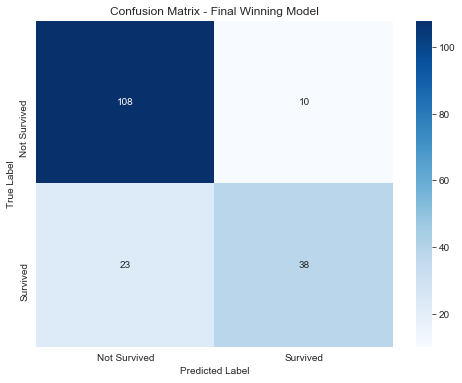


Cross-validation on test_df (5 folds, independent evaluation):
Fold 1: 0.7533
Fold 2: 0.7305
Fold 3: 0.7243
Fold 4: 0.6759
Fold 5: 0.8600

Mean F1 Score across 5 folds (test_df): 0.7488


In [36]:
X_test_final = test_df.drop('Survived', axis=1)
y_test_final = test_df['Survived']

# חיזוי על סט המבחן
y_pred_final = final_model_pipeline.predict(X_test_final)

comparison_df_head = pd.DataFrame({
    'Actual Value': y_test_final.head(5).values,
    'Model Prediction': y_pred_final[:5]
})
display(comparison_df_head)

# --- שלב 2: מטריצת בלבול ---
cm = confusion_matrix(y_test_final, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Survived', 'Survived'], 
            yticklabels=['Not Survived', 'Survived'])
plt.title("Confusion Matrix - Final Winning Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# --- שלב 5: Cross-validation עצמאי על test_df ---
cv_scores_eval = cross_val_score(final_model_pipeline, X_test_final, y_test_final, cv=5, scoring="f1_macro")

print("\nCross-validation on test_df (5 folds, independent evaluation):")
for i, score in enumerate(cv_scores_eval, 1):
    print(f"Fold {i}: {score:.4f}")

print(f"\nMean F1 Score across 5 folds (test_df): {np.mean(cv_scores_eval):.4f}")